### 1
Скачайте данные в формате csv, выберите из таблицы данные по России, начиная с 3 марта 2020 г. (в этот момент впервые стало больше 2 заболевших). В качестве целевой переменной возьмём число случаев заболевания (столбцы total_cases и new_cases); для упрощения обработки можно заменить в столбце new_cases все нули на единицы. Для единообразия давайте зафиксируем тренировочный набор в виде первых 50 отсчётов (дней), начиная с 3 марта; остальные данные можно использовать в качестве тестового набора (и он даже будет увеличиваться по мере выполнения задания).

In [67]:
import pandas as p
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
total_covid_data = pd.read_csv('owid-covid-data.csv')

In [6]:
russian_covid = total_covid_data[total_covid_data['location'] == 'Russia']
russian_covid.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
214813,RUS,Europe,Russia,2020-01-03,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214814,RUS,Europe,Russia,2020-01-04,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214815,RUS,Europe,Russia,2020-01-05,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214816,RUS,Europe,Russia,2020-01-06,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214817,RUS,Europe,Russia,2020-01-07,NaN,0.0,NaN,NaN,0.0,NaN,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


Итак, были выбраны данные по России. Легко видеть, что подвыборка данных начального периода не имеет никакого  
смысла для мини-исследрвания, так что избавимся от них, как и предложено в тексте задания.

In [13]:
# russian_covid['date'] = pd.to_datetime(russian_covid['date'])  
russian_covid_act = russian_covid[russian_covid['date'] >= '2020-03-03']
russian_covid_act = russian_covid_act.replace({'new_cases' : {0.0 : 1.0}})
russian_covid_act.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,population,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
214873,RUS,Europe,Russia,2020-03-03,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214874,RUS,Europe,Russia,2020-03-04,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214875,RUS,Europe,Russia,2020-03-05,3.0,1.0,0.143,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214876,RUS,Europe,Russia,2020-03-06,4.0,1.0,0.286,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN
214877,RUS,Europe,Russia,2020-03-07,4.0,1.0,0.286,NaN,0.0,0.0,...,58.3,NaN,8.05,72.58,0.824,144713312.0,NaN,NaN,NaN,NaN


Наконец, разделим подвыборку на train/test с соответсвии с заданием

In [17]:
threshold = russian_covid_act.iloc[0].date + pd.Timedelta("50 day")
train, test = (russian_covid_act[russian_covid_act['date'] < threshold], 
               russian_covid_act[russian_covid_act['date'] >= threshold])
print(test.shape)

(1053, 67)


Очевидно, что на тест не стоит брать данные за почти трехлетний период, когда сменилось уже несколько штаммов  
с разной степенью заразности. Чтобы отсечь границу, посмотрим целевой признак - число новых заражений.  
Допущение: отсечем все после появления омикрон-штамма (на этом моменте ожидается резкий пик).

In [51]:
def plot_feature(feature_name: str, 
                ylabel: str,
                title: str,
                slice_: int = -1) -> None:
    figsize = (18, 12)
    legend_fontsize = 10
    axis_fontsize = 16


    plt.plot(train.date, train[feature_name], label="train (50 days)", color='black')
    plt.plot(test.date[:slice_], test[feature_name][:slice_], label="test (others)", color='red')
    plt.xticks(rotation=25)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc="upper left", fontsize=legend_fontsize)

    plt.show()

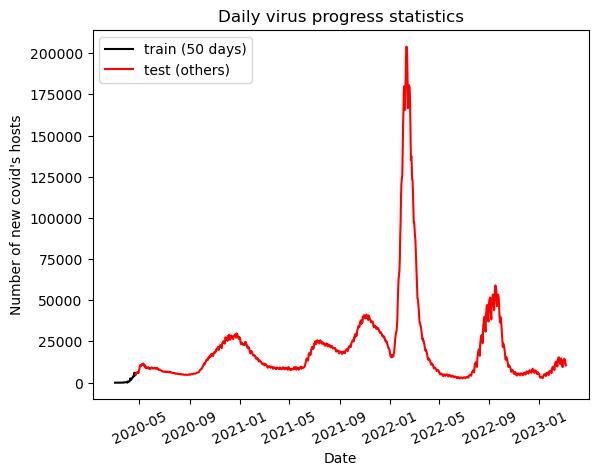

In [52]:
plot_feature(
    "new_cases",
    ylabel="Number of new covid's hosts",
    title='Daily virus progress statistics'
)

Посмотрим на целевой признак - число заражений по дням. Видим характерные пики - от оригинала до его "кентавров".  
Легко видеть (именно так), что оригинал закончился уже в январе 2021-го года, где уже наблбдается пик омикрона.  
Оценим грубо продожительность первоначального вируса в 1,5 года (или 540 дней).

In [77]:
test = test[:540]

### 2
Постройте графики целевых переменных. Вы увидите, что число заболевших растёт очень быстро, на первый взгляд экспоненциально. Для первого подхода к снаряду давайте это и используем.  
a) Используя линейную регрессию, обучите модель с экспоненциальным ростом числа заболевших: y ~ exp(линейная функция от x), где x — номер текущего дня.  
b) Найдите апостериорное распределение параметров этой модели для достаточно широкого априорного распределения. Требующееся для этого значение дисперсии шума в данных оцените, исходя из вашей же максимальной апостериорной модели (это фактически первый шаг эмпирического Байеса).  
c) Посэмплируйте много разных экспонент, постройте графики. Сколько, исходя из этих сэмплов, предсказывается случаев коронавируса в России к 1 мая? к 1 июня? к 1 сентября? Постройте предсказательные распределения (можно эмпирически, исходя из данных сэмплирования).  


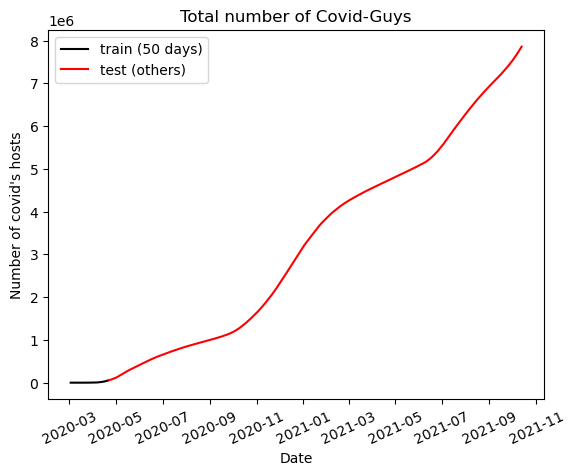

In [53]:
plot_feature(
    "total_cases",
    ylabel="Number of covid's hosts",
    title='Total number of Covid-Guys',
    slice_=540
)

Попробуем использовать экспоненту.  
Так как экспоненту наш питон не потянет (проверено), будем использовать логарифмическую шкалу

In [90]:
lr = LinearRegression()

x_train = np.arange(1, train.shape[0] + 1).reshape(-1, 1)
x_test = np.arange(train.shape[0] + 1, 
                   test.shape[0] + train.shape[0] +  1).reshape(-1, 1)

y_train = np.log(train["total_cases"]).values.reshape(-1, 1)
y_test = np.log(test["total_cases"]).values.reshape(-1, 1)

lr.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

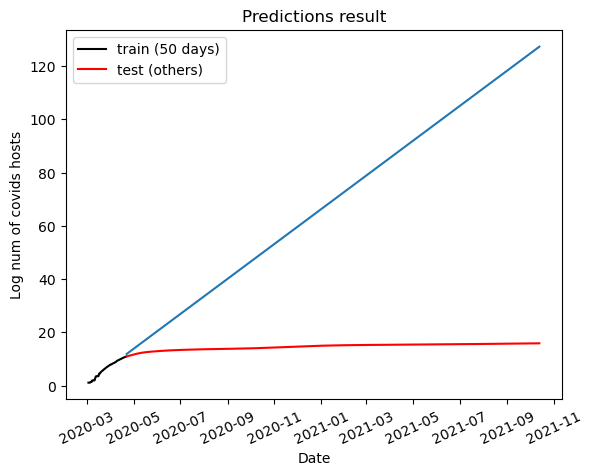

In [88]:
figsize = (18, 12)
legend_fontsize = 10
axis_fontsize = 16


plt.plot(train.date, y_train, label="train (50 days)", color='black')
plt.plot(test.date[:540], y_test, label="test (others)", color='red')
plt.plot(test.date[:540], lr_pred)
plt.xticks(rotation=25)
plt.xlabel("Date")
plt.ylabel('Log num of covids hosts')
plt.title('Predictions result')
plt.legend(loc="upper left", fontsize=legend_fontsize)

plt.show()

Результат вполне ожидаем - совершенно не отражает результат на тесте. В чем же дело?  
Объяснение довольно просто - ограниченность популяции людей, доступных для заражения, что не учитывает модель.
Иначе говоря: интеграл от экспоненты расходится, поэтому вряд ли может описать зависимость, сходящуюсю к какой-то константе.

#### Пункт b

In [92]:
# Оценка дисперсии:
delta_arr = lr.predict(x_train) - y_train
sigma = np.std(delta_arr)
print(f'sigma is {sigma}')

sigma is 0.4498899109116322
